In [1]:
import random as python_random

from matplotlib import pyplot as plt
plt.style.use('ggplot')

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 15/1.6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)


import numpy as np
import pandas as pd

import yfinance as yf

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

from keras.models import Model
from keras.models import Sequential
from keras import optimizers
from keras import layers
from sklearn.preprocessing import MinMaxScaler

In [2]:
def MAPE(y_hat,y_pred):
    mape = np.mean(np.abs((y_hat - y_pred)/y_hat))*100
    return mape

def RMSE(y_hat,y_pred):
    MSE = np.square(np.subtract(y_hat,y_pred)).mean() 
    return (MSE**(1/2))


In [3]:
phys_dev=tf.config.list_physical_devices("GPU")
if len(phys_dev)!=0:
    tf.config.experimental.set_memory_growth(phys_dev[0],True)    
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')),"\n","Tensorflow version: ", tf.__version__)

Num GPUs Available:  1 
 Tensorflow version:  2.4.1


In [57]:
#PARAMETERS
EPOCHS=30
BATCH_SIZE=256
RANDOMSEED=123
SELECTED_STOCK='MSFT'


np.random.seed(RANDOMSEED)
python_random.seed(RANDOMSEED)
tf.random.set_seed(RANDOMSEED)

gme=yf.Ticker('GME').history(start='2010-01-01',end='2021-01-01')
msft=yf.Ticker('MSFT').history(start='2010-01-01',end='2021-01-01')
stock=yf.Ticker(SELECTED_STOCK).history(start='2010-01-01',end='2021-01-01')

In [58]:
class Dataset():
    def __init__(self, data, target='Close',timeseries=True,scale=True,look_forw=1,look_back=60,test_size=0.2):
    #Store the raw data.    
        self.split=int(len(data)*(1-test_size))
        self.Scaler=None
        self.target_col=data.columns.get_loc(target)
        self.look_forw = look_forw
        self.look_back=look_back
        self.train_dates=data.iloc[:self.split,:].index
        self.test_dates=data.iloc[self.split-self.look_back:,:].index

        #self.Data=data.dropna(subset=['Close'],how='any')   
        
        self.Train = np.array(data.iloc[:self.split,:])
        self.Test = np.array(data.iloc[self.split-self.look_back:,:])

        if timeseries==True:
            self.Train=self.Train[:,self.target_col].reshape(-1,1)
            self.Test=self.Test[:,self.target_col].reshape(-1,1)  
        
        if scale==True:
            self.Scaler=MinMaxScaler(feature_range = (-1, 1))
            self.Scaler=self.Scaler.fit(self.Train)
        
            self.Train=self.Scaler.transform(self.Train)
            self.Test=self.Scaler.transform(self.Test)
        
        self.X_train_seq=[]
        self.y_train_seq=[]
        for i in range(self.look_back,len(self.Train)):
            self.X_train_seq.append(self.Train[i-self.look_back:i,:])
                
            if timeseries==True:
                self.y_train_seq.append(self.Train[i:i+self.look_forw])
            else:
                self.y_train_seq.append(self.Train[i:i+self.look_forw,self.target_col])

        self.X_train_seq=np.array(self.X_train_seq).astype('float32')
        self.y_train_seq=np.array(self.y_train_seq,dtype='object').astype('float32')

        self.X_train_seq=self.X_train_seq.reshape(self.X_train_seq.shape[0],self.X_train_seq.shape[1],self.X_train_seq.shape[2])

        self.X_test_seq=[]
        for i in range(self.look_back,len(self.Test)):
                self.X_test_seq.append(self.Test[i-self.look_back:i,:])
                
        self.X_test_seq=np.asarray(self.X_test_seq).astype('float32')
        self.X_test_seq=self.X_test_seq.reshape(self.X_test_seq.shape[0],self.X_test_seq.shape[1],self.X_test_seq.shape[2])

        print(self.__repr__())

    def __repr__(self):
        return '\n'.join([
        f'Original train and test{self.Train.shape,self.Test.shape}',
        f'X train size {self.X_train_seq.shape}',
        f'Y train size: {self.y_train_seq.shape}',
        f'X test size: {self.X_test_seq.shape}'])

In [59]:
bench_data=Dataset(stock,look_back=60,timeseries=True,scale=True)
bench_input_shape=(bench_data.look_back,bench_data.X_train_seq.shape[2])
data=Dataset(stock,look_back=60,timeseries=False,scale=True)
true_stock=stock.Close[data.split:].values
input_shape=(data.look_back,data.X_train_seq.shape[2])

Original train and test((2216, 1), (614, 1))
X train size (2156, 60, 1)
Y train size: (2156, 1, 1)
X test size: (554, 60, 1)
Original train and test((2216, 7), (614, 7))
X train size (2156, 60, 7)
Y train size: (2156, 1)
X test size: (554, 60, 7)


In [70]:
_mape=tf.keras.metrics.MeanAbsolutePercentageError()
_rmse=tf.keras.metrics.RootMeanSquaredError()

In [69]:
bench_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)

benchmark_lstm = Sequential([
    layers.LSTM(units=50, return_sequences=True,input_shape=bench_input_shape),
    layers.LSTM(units=50, return_sequences=False),
    layers.Dense(units=1,activation='linear')
])   

benchmark_lstm.compile(optimizer=bench_optimizer,loss=['mse'],metrics=[_mape])

keras.backend.clear_session()

benchmark_history=benchmark_lstm.fit(bench_data.X_train_seq,bench_data.y_train_seq,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                shuffle=False,
                verbose=0,
                validation_split=0.1
                )

preds_scaled=benchmark_lstm.predict(bench_data.X_test_seq)
preds=bench_data.Scaler.inverse_transform(np.repeat(preds_scaled,bench_data.Train.shape[1],axis=1))
benchmark_preds=preds[:,0]

In [71]:
#CALLBACKS
es=EarlyStopping(monitor='val_loss',min_delta=1e-2,mode="min",patience=5,verbose=1)
rlr=ReduceLROnPlateau(monitor='val_loss',min_delta=1e-2,factor=0.75,cooldown=5,mode='min',patience=3,verbose=1)

#PARAMS
drop_rate=0.8
activation_func='elu'

kernel_reg=keras.regularizers.l1_l2(l1=0.01, l2=0.01)
bias_reg=keras.regularizers.l1_l2(l1=0.01, l2=0.01)
recurrent_reg=keras.regularizers.l1_l2(l1=0.001, l2=0.001)
act_reg=keras.regularizers.l1_l2(l1=0.001, l2=0.001)

optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)

In [73]:
opt_lstm = Sequential([
    layers.LSTM(units=50, return_sequences=True,input_shape=input_shape,activation=activation_func
                ,kernel_regularizer=kernel_reg,bias_regularizer=bias_reg
                ),
    layers.Dropout(drop_rate),
    layers.LSTM(units=50, return_sequences=False
                #,activation=activation_func
                ),
    layers.Dropout(drop_rate),
    layers.Dense(units=1,activation='linear')
]) 
  
opt_lstm.compile(optimizer=optimizer,loss=['mse'],metrics=[_mape])

In [74]:
keras.backend.clear_session()
opt_history=opt_lstm.fit(data.X_train_seq,data.y_train_seq,
                epochs=500,
                batch_size=512,
                validation_split=0.1,
                verbose=0,
                callbacks=[es,rlr]
                )

KeyboardInterrupt: 

In [65]:
preds_scaled=opt_lstm.predict(data.X_test_seq)
preds=data.Scaler.inverse_transform(np.repeat(preds_scaled,data.Train.shape[1],axis=1))
opt_preds=preds[:,0]

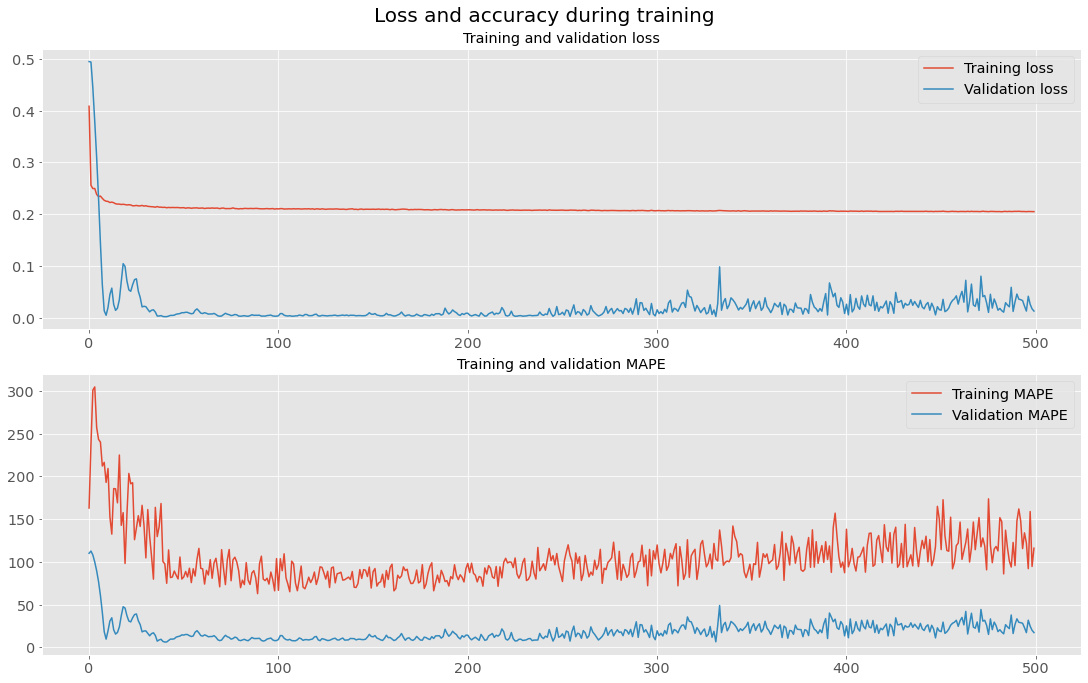

In [66]:
fig, axs = plt.subplots(2,figsize=(15,15/1.6), constrained_layout=True)
fig.suptitle('Loss and accuracy during training',fontsize=20)

axs[0].plot(opt_history.history['loss'],label='Training loss')
axs[0].plot(opt_history.history['val_loss'],label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].legend()

axs[1].plot(opt_history.history['mean_absolute_percentage_error'],label='Training MAPE')
axs[1].plot(opt_history.history['val_mean_absolute_percentage_error'],label='Validation MAPE')
axs[1].set_title('Training and validation MAPE')
axs[1].legend()
plt.show()

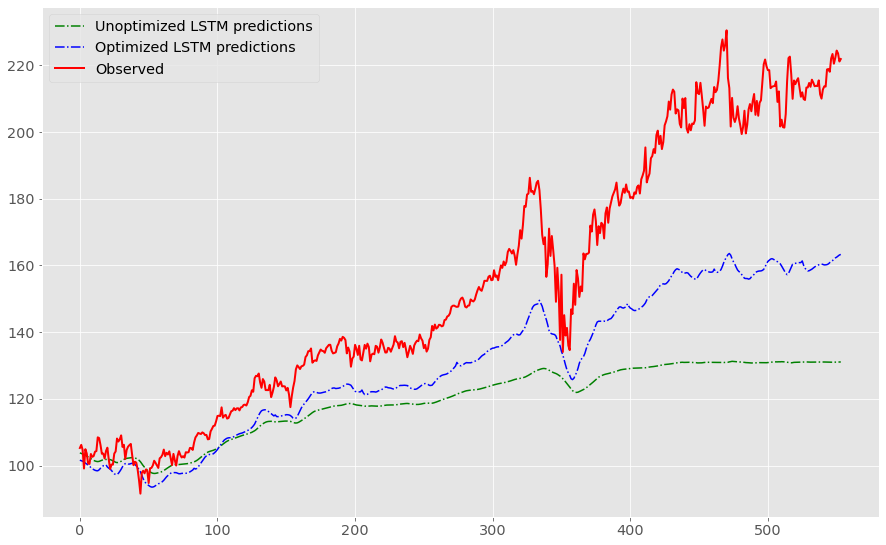

In [67]:
plt.plot(benchmark_preds,'g-.',label="Unoptimized LSTM predictions")
plt.plot(opt_preds,'b-.',label="Optimized LSTM predictions")
plt.plot(true_stock,'r-',linewidth=2,label="Observed")
plt.legend()
plt.show()

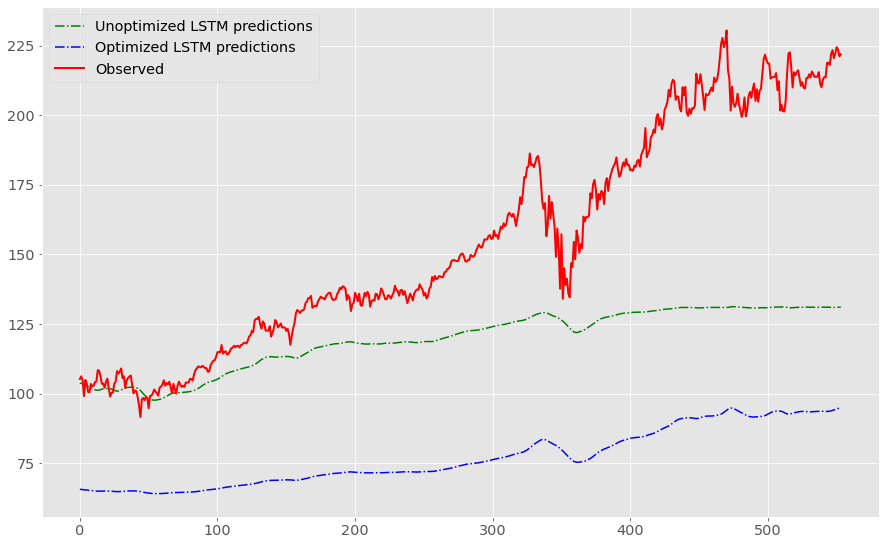

In [17]:
plt.plot(benchmark_preds,'g-.',label="Unoptimized LSTM predictions")
plt.plot(opt_preds,'b-.',label="Optimized LSTM predictions")
plt.plot(true_stock,'r-',linewidth=2,label="Observed")
plt.legend()
plt.show()